### Rotational Correlation in Water
This document just details how we most easily could think up an analysis of the convergence of the total dipole moment of a simulation box with time, if the total dipole moment is simply expressed as a sum of vectors basically defining the orientation of each water molecule. If that is the case, the question is really about the rotational correlation time in water. 



Init some stuff:

In [219]:
%reset -f 
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{cmbright}')
import warnings
warnings.filterwarnings("ignore")
ncs = plt.rcParams['axes.prop_cycle'].by_key()['color']
matplotlib.rcParams.update({'font.size': 16})
from ase.io import Trajectory

Simple check of the total static 'dipole' in an MD simulation of TIP4P water.


The molecular 'dipoles' are defined as vectors from the oxygen centers, out to the center between the Hydrogen atoms. 


The simulation is just 20 ps of 1000 water molecules at 300 K, with a Langevin thermostat.


We're using ASE to handle trajectories etc (https://wiki.fysik.dtu.dk/ase/ ), but it should be rather simple to change to a series of .xyz files instead, if one should be so inclined... 


##### Load data, get dipoles

In [51]:
import numpy as np
from ase.io.trajectory import Trajectory

t = 'tip4p_1000mol_20ps.traj'
traj = Trajectory(t) 

steps = range(len(traj))
dtot = np.zeros((len(steps), 3)) 

for step, atoms in enumerate(traj):
    atoms.set_constraint()  
    r = atoms.get_positions()

    # make the dipoles
    d = (r[1::3, :] + r[2::3, :]) / 2 - r[::3, :]
    dn = d / np.linalg.norm(d, axis=1)[:, None]  # (correct) normalization this time :) 

    dtot[step] = np.sum(dn, axis=0)  # total dipole of this step

# The frames were saved to the trajectory every 100 steps, with a 2fs timestep:
real_time = np.arange(len(dtot)) * 200 / 1e3



##### Simple time evolution of total dipole

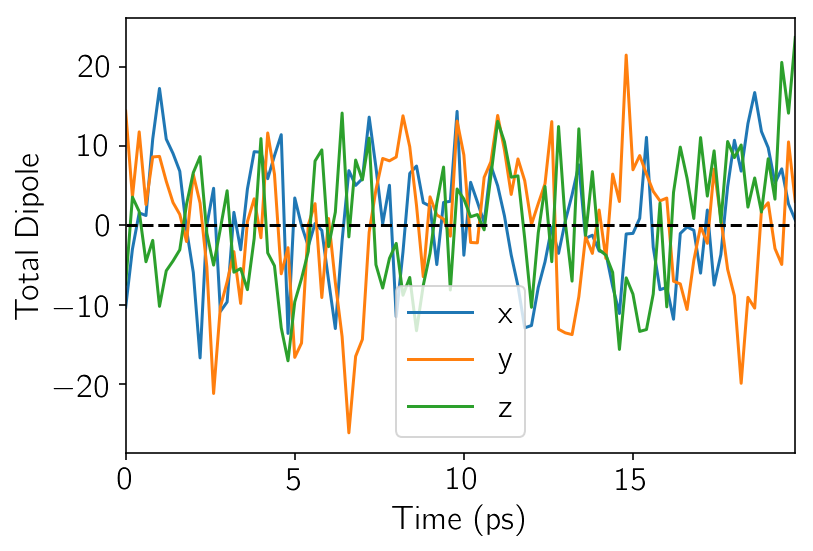

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
dims = ['x', 'y', 'z']
for dim in [0, 1 ,2]:
    ax.plot(real_time, dtot[:, dim], label=dims[dim])
ax.plot(real_time, np.zeros(len(steps)) , 'k--' );
ax.legend(loc='best')
ax.set_xlim([0, real_time[-1]])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Total Dipole');

Looks to oscillate quite a bit, but more or less centered around 0...

##### Cumulative average

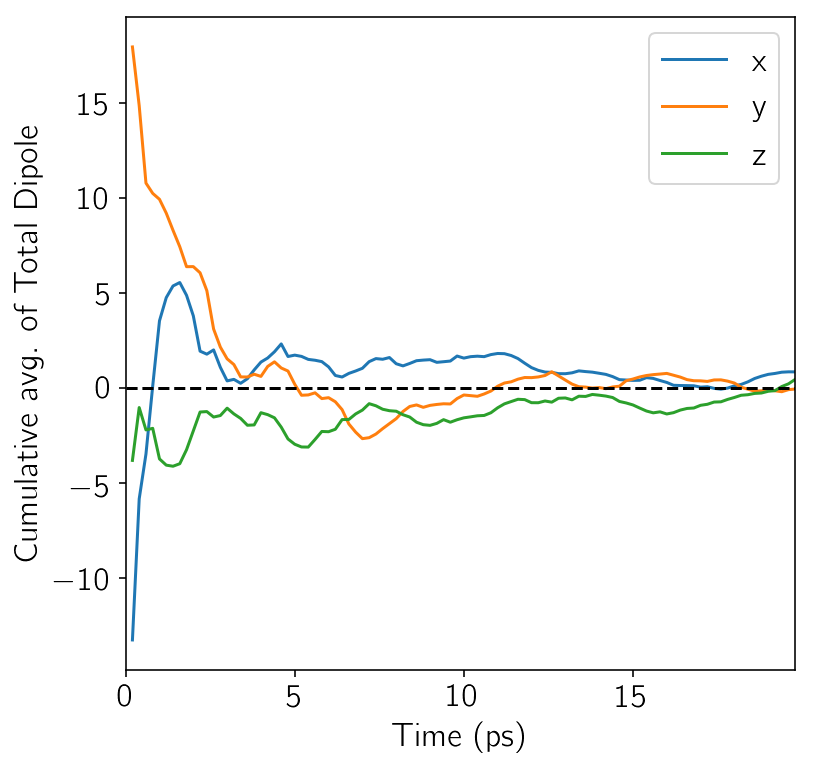

In [53]:
# Plot the cumulative sum of the total dipoles divided by the number of frames 
# to get the cumulative average
fig, ax = plt.subplots(1,1, figsize=(6, 6))
dims = ['x', 'y', 'z']
for dim in [0, 1 ,2]:
    ax.plot(real_time, np.cumsum(dtot[:, dim]) / steps, label=dims[dim])
ax.plot(real_time, np.zeros(len(steps)) , 'k--' )    

ax.legend(loc='best')
ax.set_xlim([0, real_time[-1]])
ax.set_xlabel('Time (ps)')
ax.set_ylabel('Cumulative avg. of Total Dipole');

So for this analysis, the rotational correlation seems to die out within 5-10 ps. There is still fluctuations, but our statistics are also quite a bit smaller than what you have. 

These ballpark time scales seem to make sense, since the rotational correlation time of water should be around 1.7 ps (https://onlinelibrary.wiley.com/doi/abs/10.1002/bbpc.19820860308 )


### The actual orientational autocorrelation function
In 10.1103/PhysRevE.73.041505  they define this function as  

\begin{equation}
C_1(t) = \left< \sum_{i=1}^N \mu_i(t) \cdot \mu_i(0)  \right> 
= \frac{1}{N} \sum_{i=1}^N <\cos \theta_i(t) >,
\end{equation}

where $\theta_i(t)$ is the angle between $\mu_i(t)$ and $\mu_i(0)$. $\mu_i(t)$ is the normalized dipole vectors of each water molecule $i$ in the system. 

I'd like to try and evaluate this as in the paper, from all dipoles, and also from the total dipole of the system. We're probably going to need averaging over many trajectories or windows of a long trajectory to get get a converged result.

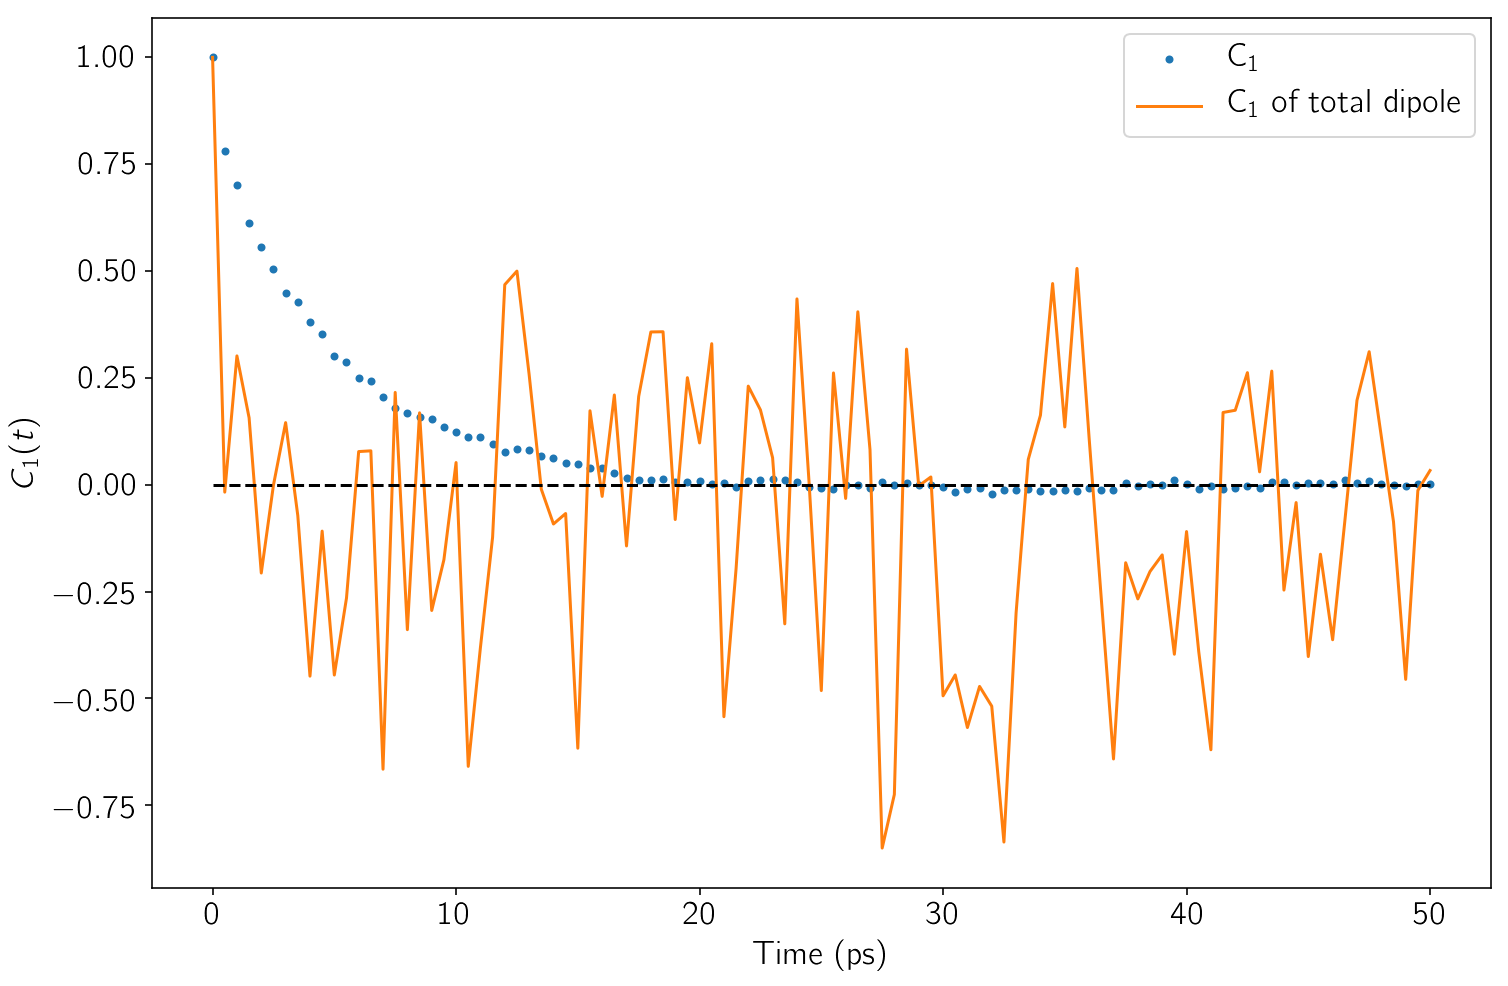

In [220]:
def rot_corr(v, dt, chunks):
    ''' Calculate Rotational Correlation from 
        an array v with shape (steps, molecules, xyz) '''
    
    ws = v.shape[0] // chunks
    C = np.zeros(ws)

    for chunk in range(chunks):
        this_chunk = v[chunk * ws:(chunk + 1) * ws, :, :]
        for step in range(ws) :
            all_dots = np.einsum('ij, ij->i',  # dot product along row. 
                                 this_chunk[0] ,
                                 this_chunk[step])
            C[step] += np.mean(all_dots)
            
    C /= chunks
    real_time = np.arange(ws) * dt
    
    return real_time, C

# dt = 200 / 1e3
# Longer traj, more statistics
traj = Trajectory('/mnt/sda3/QMShellProject/WaterBox/tip4p_1000mol_1ns.traj')
dt = 2 * 250  /1e3
    
# Make the array of dipoles
steps = range(len(traj))
nmol = len(traj[0]) // 3
dtot = np.zeros((len(steps), 3)) 
dips = np.zeros((len(steps), nmol, 3))
for step, atoms in enumerate(traj):
    atoms.set_constraint()  
    r = atoms.get_positions()

    # make the dipoles
    d = (r[1::3, :] + r[2::3, :]) / 2 - r[::3, :]
    dn = d / np.linalg.norm(d, axis=1)[:, None]  

    dips[step, :, :] = dn
    dtot[step] = np.sum(dn, axis=0) 

dtot = dtot / np.linalg.norm(dtot, axis=1)[:, None]  
    
chunks = 3
t, Call = rot_corr(dips, dt, chunks)
t, Ctot = rot_corr(dtot[:, None], dt, chunks)

fig, ax = plt.subplots(1,1, figsize=(12, 8))
ax.plot(t, Call, '.', label='C$_1$');
ax.plot(t, Ctot, label='C$_1$ of total dipole');
ax.plot(t, np.zeros_like(t), 'k--');
ax.legend(loc='best')
ax.set_ylabel('$C_1(t)$')
ax.set_xlabel('Time (ps)');

So the orientational autocorrelation function of the individual dipoles make sense, and is something you can look at that has a more established way of confirming the validity of your simulations. 

Note, that in the above, the total dipole is also normalized. We can of course also _not_ do this, which changes the scale, evolution is the same. 


I think that we can confidently say that if this is how the behaviour of the _total_ dipole looks when the autocorrelation function of the _individual_ dipoles are indeed behaving as expected, this must be how the total dipole _should_ look.


To further compare with the previously mentioned paper, we can also compare our orientational correlation time $\tau_a$ from equation (1) in the paper:

$$
\phi(t) = A \exp\left(- \left( \frac{t}{\tau_a}\right)^\beta  \right)
$$

Fitted tau: 4.19 ps


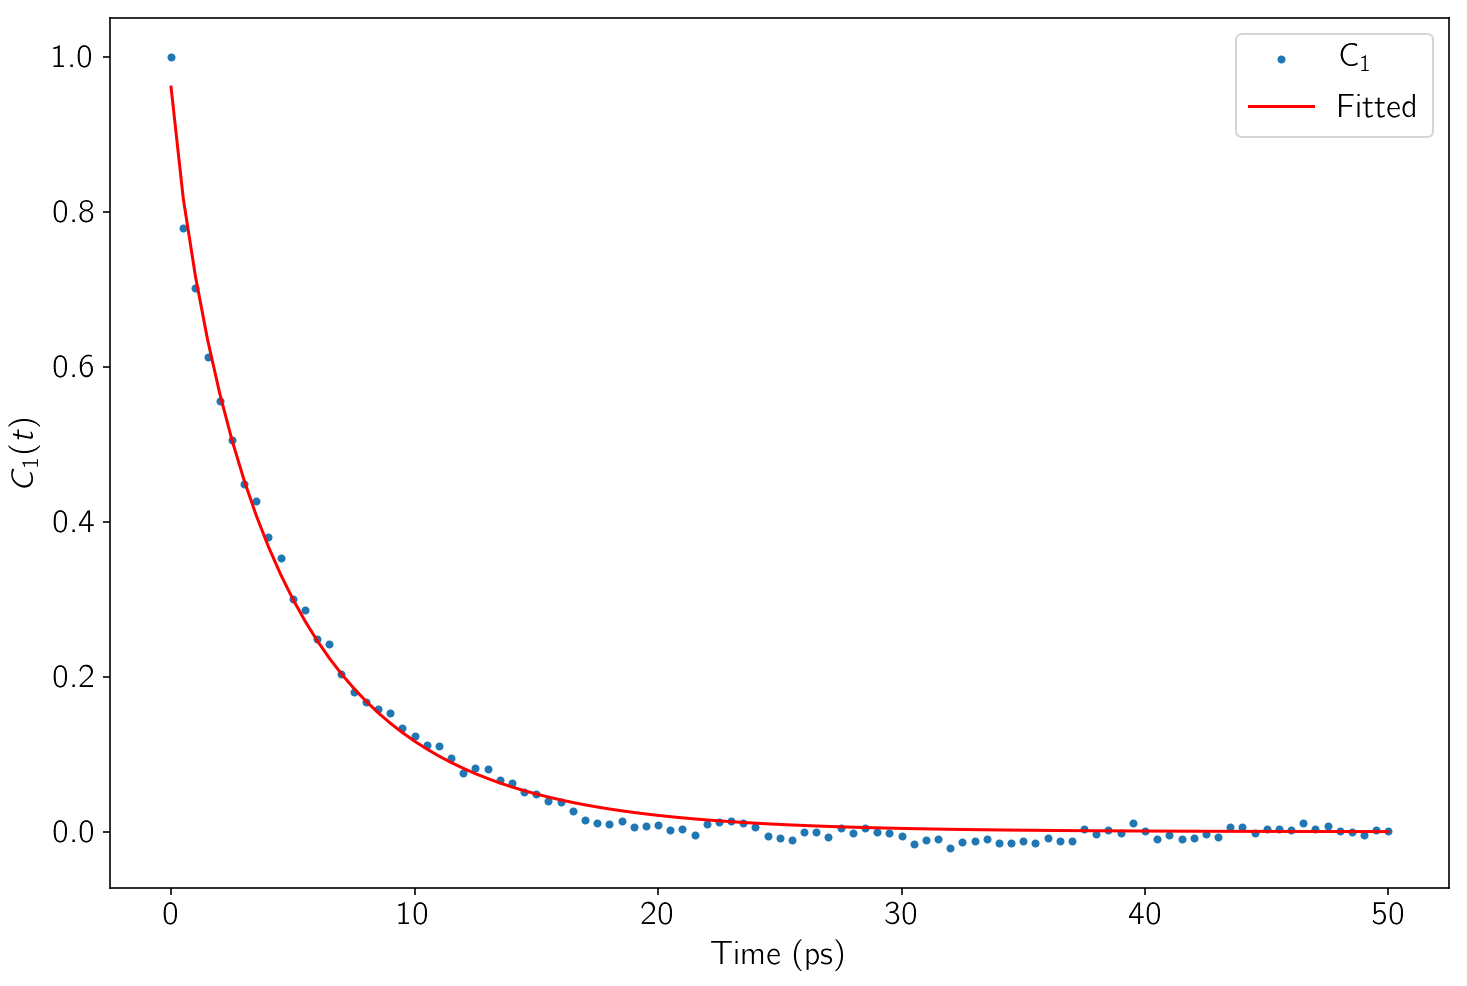

In [221]:
from scipy.optimize import curve_fit

def relax(t, tau, A, beta):
    return A * np.exp(-(t / tau)**beta)

popt, pcov = curve_fit(relax, t, Call) 
    
fig, ax = plt.subplots(1,1, figsize=(12, 8))
ax.plot(t, Call, '.', label='C$_1$');
ax.plot(t, relax(t, popt[0], popt[1], popt[2]), 'r', label='Fitted');

print('Fitted tau: {0:2.2f} ps'.format(popt[0]))
ax.legend(loc='best')
ax.set_ylabel('$C_1(t)$')
ax.set_xlabel('Time (ps)');

The paper, using a different thermostat and another force field (!) gets $\tau_a = 4.9 $ ps. We are roughly half to a full ps off (depending on windowing), but that is to be expected with the differences in methods. 